In [2]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import EarlyStopping
from math import sqrt
from matplotlib import pyplot
import numpy


/home/sam/Documents/projects/practice/general/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """
2024-06-11 12:54:34.659233: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-11 12:54:35.558955: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /u01/app/oracle/product/11.2.0/xe/lib:
2024-06-11 12:54:35.559023: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could n

In [4]:
series = read_csv('../data/single bill for cluster 0.csv', usecols=[1], engine='python')
series00 = read_csv('../data/single bill cluster 00.csv', usecols=[1], engine='python')
series000 = read_csv('../data/single bill cluster 000.csv', usecols=[1], engine='python')
series0000 = read_csv('../data/single bill cluster 0000.csv', usecols=[1], engine='python')
series00000 = read_csv('../data/single bill cluster 00000.csv', usecols=[1], engine='python')

# transform data to be stationary
raw_values = series.values
raw_values00 = series00.values
raw_values000 = series000.values
raw_values0000 = series0000.values
raw_values00000 = series00000.values

In [7]:
series2 = read_csv('../data/single bill for cluster 1.csv', usecols=[1], engine='python')
series22 = read_csv('../data/single bill culster 11.csv', usecols=[1], engine='python')
series222 = read_csv('../data/single bill culster 111.csv', usecols=[1], engine='python')
series2222 = read_csv('../data/single bill for cluster 1111.csv', usecols=[1], engine='python')
series22222 = read_csv('../data/single bill culster 11111.csv', usecols=[1], engine='python')


# transform data to be stationary
raw_values2 = series2.values
raw_values22 = series22.values
raw_values222 = series222.values
raw_values2222 = series2222.values
raw_values22222 = series22222.values


In [11]:
series3 = read_csv('../data/single bill for cluster 2.csv .csv', usecols=[1], engine='python')
series33 = read_csv('../data/single bill culster 22.csv', usecols=[1], engine='python')
series333 = read_csv('../data/single bill culster 222.csv', usecols=[1], engine='python')
series3333 = read_csv('../data/single bill culster 2222.csv', usecols=[1], engine='python')
series33333 = read_csv('../data/single bill cluster 22222.csv', usecols=[1], engine='python')


# transform data to be stationary
raw_values3 = series3.values
raw_values33 = series33.values
raw_values333 = series333.values
raw_values3333 = series3333.values
raw_values33333 = series33333.values

In [12]:
def timeseries_to_supervised(data, lag=1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df

In [13]:
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
	new_row = [x for x in X] + [value]
	array = numpy.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]

In [14]:


# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons, patience=3):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	model = Sequential()
	model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam')

	early_stopping = EarlyStopping(monitor='loss', patience=patience, restore_best_weights=True)

	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False, callbacks=[early_stopping])
		model.reset_states()
	return model

# make a one-step forecast
def forecast_lstm(model, batch_size, X):
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]

In [62]:
### Global Variables
NB_EPOCH = 10
NEURONS = 32
BATCH_SIZE = 1

In [68]:
def train(value):
	diff_values = difference(value, 1)

	# transform data to be supervised learning
	supervised = timeseries_to_supervised(diff_values, 1)
	supervised_values = supervised.values

	# split data into train and test-sets
	train, test = supervised_values[0:-3], supervised_values[-3:]

	# transform the scale of the data
	scaler, train_scaled, test_scaled = scale(train, test)

	# fit the model
	lstm_model = fit_lstm(train_scaled, BATCH_SIZE, NB_EPOCH, NEURONS)
	# forecast the entire training dataset to build up state for forecasting
	train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
	lstm_model.predict(train_reshaped, batch_size=1)

	# walk-forward validation on the test data
	predictions = list()
	for i in range(len(test_scaled)):
		# make one-step forecast
		X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
		yhat = forecast_lstm(lstm_model, 1, X)
		# invert scaling
		yhat = invert_scale(scaler, X, yhat)
		# invert differencing
		yhat = inverse_difference(value, yhat, len(test_scaled)+1-i)
		# store forecast
		predictions.append(yhat)
		expected = value[len(train) + i + 1]
		print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


	# report performance
	rmse = sqrt(mean_squared_error(value[-3:], predictions))
	print('Test RMSE: %.3f' % rmse)

	mae = mean_absolute_error(value[-3:], predictions)
	print('Test MAE: %.3f' % mae)
	# line plot of observed vs predicted
	pyplot.plot(raw_values[-3:])
	pyplot.plot(predictions)
	pyplot.show()

### For Cluster 0

1/1 [==============================] - 0s 23ms/step
Month=1, Predicted=1121.325364, Expected=2107.000000
1/1 [==============================] - 0s 20ms/step
Month=2, Predicted=1418.115852, Expected=1324.000000
1/1 [==============================] - 0s 15ms/step
Month=3, Predicted=1564.833820, Expected=1050.000000
Test RMSE: 644.326
Test MAE: 531.541


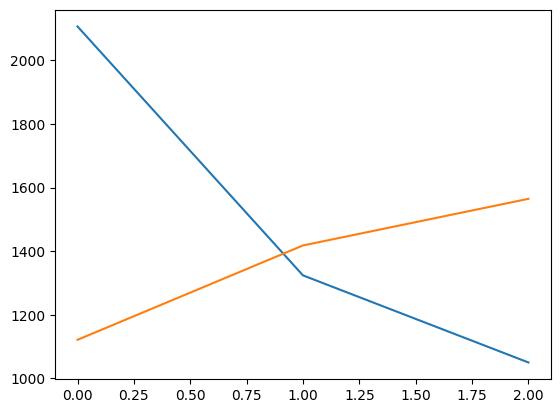

In [69]:
train(raw_values)

1/1 [==============================] - 0s 12ms/step
Month=1, Predicted=810.842652, Expected=411.000000
1/1 [==============================] - 0s 14ms/step
Month=2, Predicted=664.962350, Expected=681.000000
1/1 [==============================] - 0s 13ms/step
Month=3, Predicted=832.242414, Expected=940.000000
Test RMSE: 239.265
Test MAE: 174.546


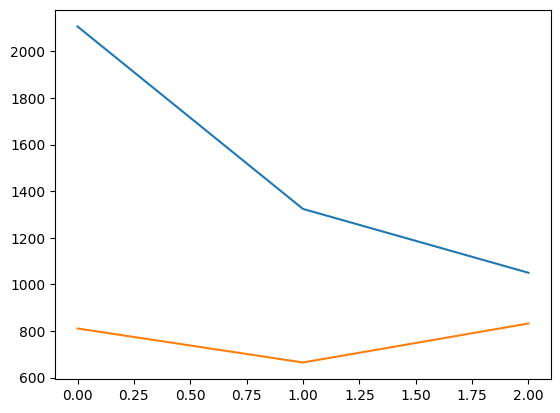

In [70]:
train(raw_values00)

1/1 [==============================] - 0s 12ms/step
Month=1, Predicted=1450.786541, Expected=1317.000000
1/1 [==============================] - 0s 12ms/step
Month=2, Predicted=1059.875914, Expected=175.000000
1/1 [==============================] - 0s 12ms/step
Month=3, Predicted=545.917763, Expected=2368.000000
Test RMSE: 1172.019
Test MAE: 946.915


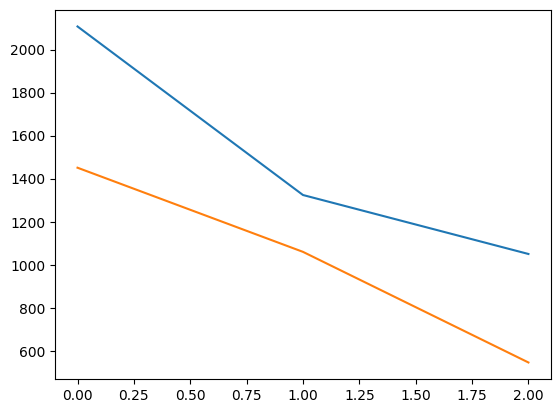

In [71]:
train(raw_values000)

1/1 [==============================] - 0s 14ms/step
Month=1, Predicted=1707.019617, Expected=1486.000000
1/1 [==============================] - 0s 14ms/step
Month=2, Predicted=1275.837862, Expected=1032.000000
1/1 [==============================] - 0s 14ms/step
Month=3, Predicted=1120.003623, Expected=797.000000
Test RMSE: 266.232
Test MAE: 262.620


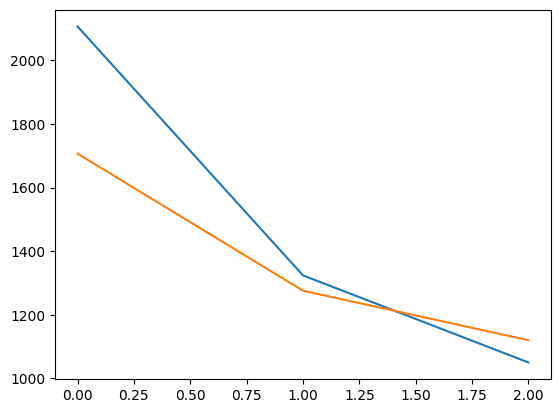

In [72]:
train(raw_values0000)

1/1 [==============================] - 0s 15ms/step
Month=1, Predicted=1103.291419, Expected=615.000000
1/1 [==============================] - 0s 14ms/step
Month=2, Predicted=976.317748, Expected=2275.000000
1/1 [==============================] - 0s 15ms/step
Month=3, Predicted=1260.915954, Expected=1845.000000
Test RMSE: 869.130
Test MAE: 790.353


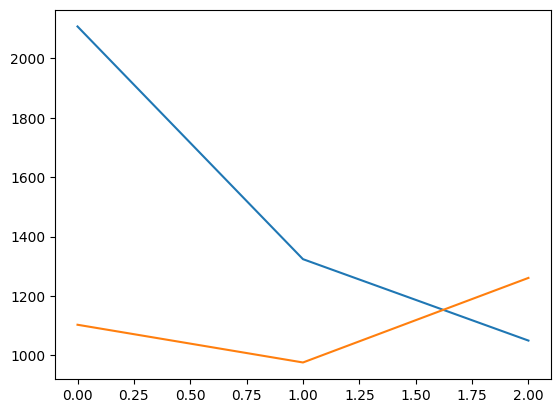

In [73]:
train(raw_values00000)

### For Cluster 1

1/1 [==============================] - 0s 12ms/step
Month=1, Predicted=364.717049, Expected=53.000000
1/1 [==============================] - 0s 12ms/step
Month=2, Predicted=203.187573, Expected=185.000000
1/1 [==============================] - 0s 15ms/step
Month=3, Predicted=266.016551, Expected=52.000000
Test RMSE: 218.557
Test MAE: 181.307


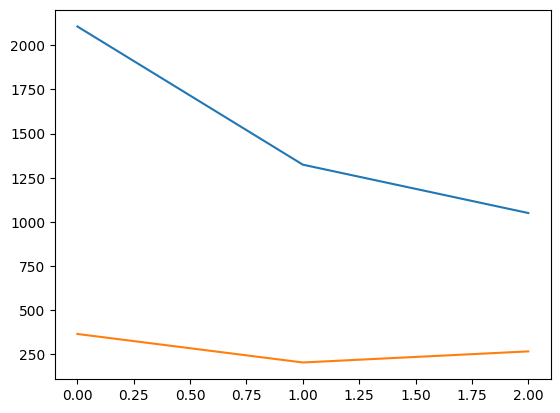

In [74]:
train(raw_values2)

1/1 [==============================] - 0s 12ms/step
Month=1, Predicted=393.340988, Expected=198.000000
1/1 [==============================] - 0s 13ms/step
Month=2, Predicted=241.710328, Expected=426.000000
1/1 [==============================] - 0s 11ms/step
Month=3, Predicted=362.451788, Expected=67.000000
Test RMSE: 230.516
Test MAE: 225.027


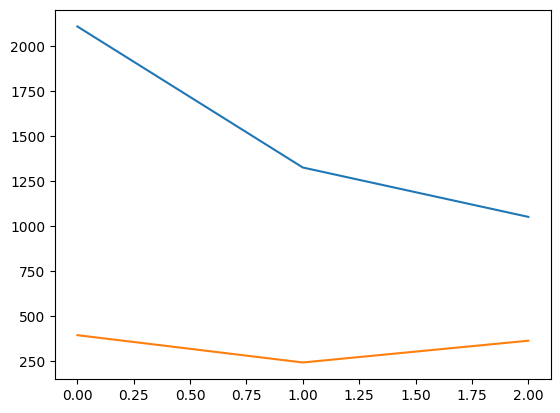

In [75]:
train(raw_values22)

1/1 [==============================] - 0s 13ms/step
Month=1, Predicted=394.274198, Expected=116.000000
1/1 [==============================] - 0s 14ms/step
Month=2, Predicted=291.618608, Expected=351.000000
1/1 [==============================] - 0s 13ms/step
Month=3, Predicted=400.398988, Expected=489.000000
Test RMSE: 172.059
Test MAE: 142.086


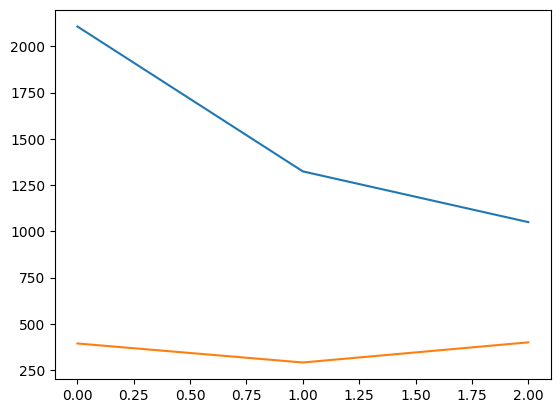

In [76]:
train(raw_values222)

1/1 [==============================] - 0s 11ms/step
Month=1, Predicted=360.347478, Expected=425.000000
1/1 [==============================] - 0s 12ms/step
Month=2, Predicted=349.057742, Expected=202.000000
1/1 [==============================] - 0s 14ms/step
Month=3, Predicted=266.642357, Expected=377.000000
Test RMSE: 112.524
Test MAE: 107.356


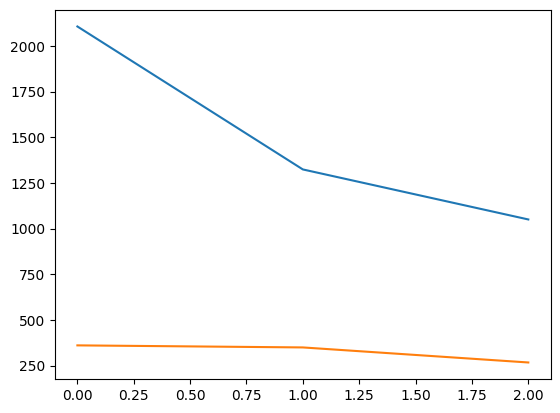

In [77]:
train(raw_values2222)

1/1 [==============================] - 0s 12ms/step
Month=1, Predicted=262.175578, Expected=273.000000
1/1 [==============================] - 0s 15ms/step
Month=2, Predicted=245.417387, Expected=377.000000
1/1 [==============================] - 0s 14ms/step
Month=3, Predicted=290.589867, Expected=97.000000
Test RMSE: 135.288
Test MAE: 111.999


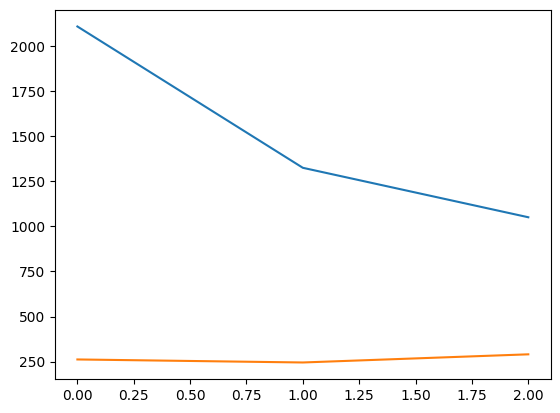

In [78]:
train(raw_values22222)

### For Cluster 2

1/1 [==============================] - 0s 24ms/step
Month=1, Predicted=3038.580611, Expected=2889.000000
1/1 [==============================] - 0s 18ms/step
Month=2, Predicted=2936.280925, Expected=2209.000000
1/1 [==============================] - 0s 18ms/step
Month=3, Predicted=2664.297943, Expected=2589.000000
Test RMSE: 430.883
Test MAE: 317.386


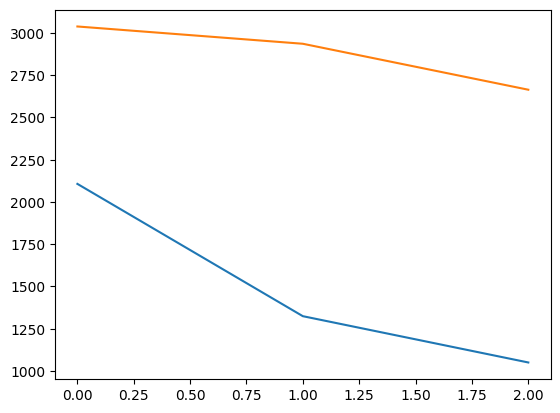

In [79]:
train(raw_values3)

1/1 [==============================] - 0s 12ms/step
Month=1, Predicted=3178.563731, Expected=3230.000000
1/1 [==============================] - 0s 15ms/step
Month=2, Predicted=3074.893861, Expected=2047.000000
1/1 [==============================] - 0s 12ms/step
Month=3, Predicted=2841.097366, Expected=3075.000000
Test RMSE: 609.350
Test MAE: 437.744


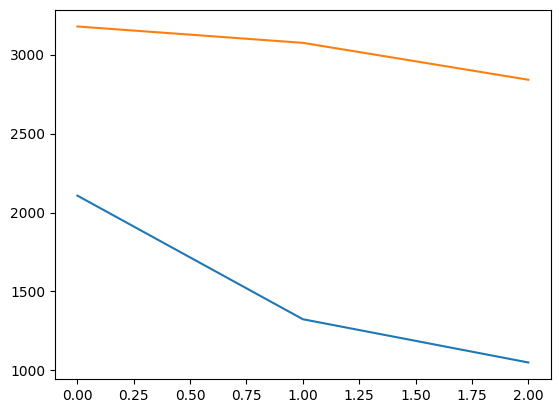

In [85]:
train(raw_values33)

1/1 [==============================] - 0s 12ms/step
Month=1, Predicted=2841.901124, Expected=2119.000000
1/1 [==============================] - 0s 12ms/step
Month=2, Predicted=2720.297162, Expected=3889.000000
1/1 [==============================] - 0s 12ms/step
Month=3, Predicted=3192.829580, Expected=2335.000000
Test RMSE: 935.294
Test MAE: 916.478


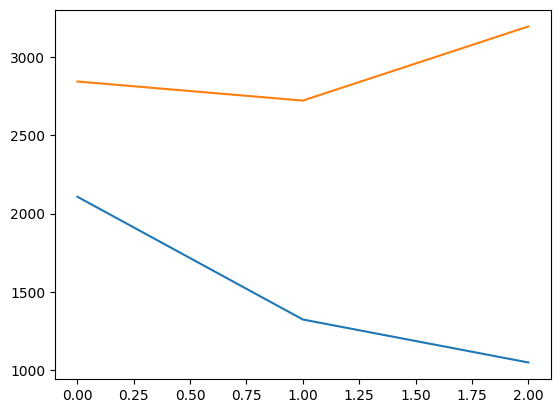

In [84]:
train(raw_values333)

1/1 [==============================] - 0s 16ms/step
Month=1, Predicted=3329.370821, Expected=3266.000000
1/1 [==============================] - 0s 13ms/step
Month=2, Predicted=3400.060757, Expected=2870.000000
1/1 [==============================] - 0s 12ms/step
Month=3, Predicted=3353.444191, Expected=3473.000000
Test RMSE: 315.845
Test MAE: 237.662


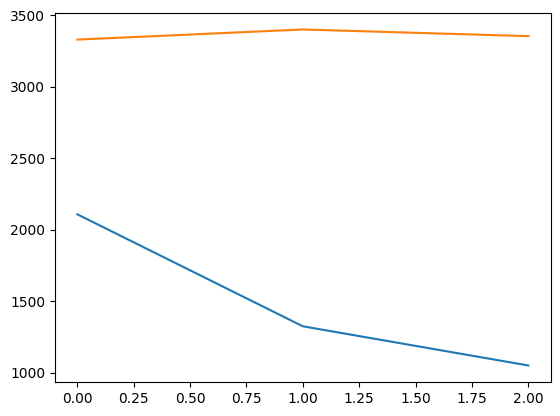

In [83]:
train(raw_values3333)

1/1 [==============================] - 0s 13ms/step
Month=1, Predicted=3548.041382, Expected=2157.000000
1/1 [==============================] - 0s 11ms/step
Month=2, Predicted=2768.886243, Expected=3886.000000
1/1 [==============================] - 0s 12ms/step
Month=3, Predicted=3708.420990, Expected=3246.000000
Test RMSE: 1064.076
Test MAE: 990.192


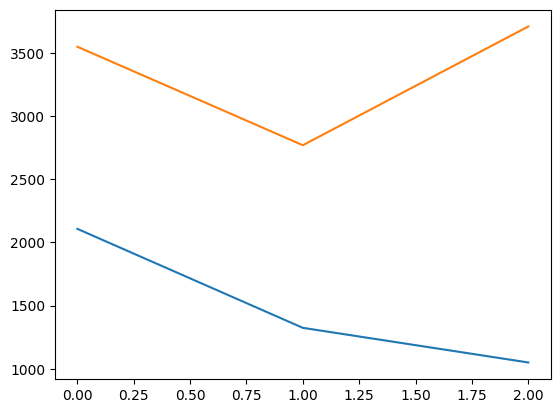

In [82]:
train(raw_values33333)